# PyTorch Introduction

PyTorch is an open-source deep learning framework developed by Facebook's AI Research lab. In recent years, it has become one of, if not the most, popular libraries for machine learning algorithms based on neural networks. PyTorch's tensor-based operations, similar to Numpy array operations, are optimized for use on GPUs and CPUs, enabling efficient handling of large datasets and complex computations.

In this notebook, we will port a simple feedforward neural network for classifying handwritten digits written in Numpy to PyTorch. The following code block imports libraries we need for the Numpy implementation. We will import additional libraries for PyTorch later.

In [1]:
import pathlib

from ipywidgets import interact
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import polars as pl
import seaborn as sns
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

sns.set_style('whitegrid')

## Data preparation

The following code block reads the feature data (`feature_data`) and the labels (`target_data`).

In [2]:
feature_data = pl.read_parquet('data/mnist_features.parquet')
target_data = pl.read_parquet(
    'data/mnist_target.parquet'
).rename({
    'class': 'label'
}).with_columns(
    pl.col('label').cast(pl.Int64)
)

print(f' - {feature_data.shape = }')

 - feature_data.shape = (70000, 784)


The output of the previous cell shows we have 70,000 instances in our dataset. Each instance is a 784-dimensional vector of pixel values that can be used to reconstruct MNIST images. The target data is simply a number corresponding to each instance's digit. The following code block splits the data into three sets: 1) training, 2) validation, and 3)testing sets. The feature data for each set is divided by 255 to scale the data to [0, 1]. The shape of feature data for each set is printed. 

In [3]:
X_train_validation, X_test, y_train_validation, y_test = train_test_split(
    feature_data.to_numpy(), 
    target_data.to_dummies().to_numpy(), 
    test_size=10_000, 
    random_state=42,
    stratify=target_data,
)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train_validation, 
    y_train_validation, 
    test_size=10_000, 
    random_state=42,
    stratify=y_train_validation,
)

X_train = X_train / 255.0
X_validation = X_validation / 255.0
X_test = X_test / 255.0

print(f' - {X_train.shape = }')
print(f' - {X_validation.shape = }')
print(f' - {X_test.shape = }')

 - X_train.shape = (50000, 784)
 - X_validation.shape = (10000, 784)
 - X_test.shape = (10000, 784)


## Numpy Implementation

The following code block defines hyperparameters for the Numpy implementation of a simple feedforward neural network. The network:
1. Has an input layer with 784 neurons,
2. Has a single hidden layer with 64 neurons,
3. Has an output layer with 10 neurons,
4. Passes outputs of the hidden layer through Sigmoid activation functions, and
5. Use a Softmax function to normalize outputs of the final layer so they correspond to a probability distribution.

In [4]:
input_size = 784  
hidden_size = 64  
output_size = 10
learning_rate = 0.3
epochs = 250

The following code block implements and runs the Numpy neural network model.

Training:   0%|          | 0/250 [00:00<?, ?it/s]

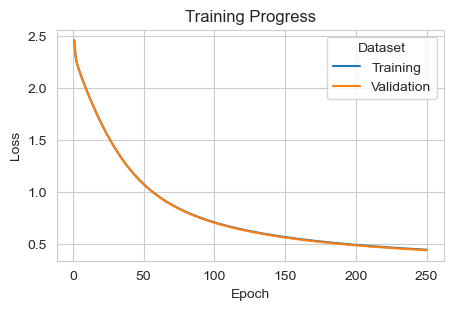

Test accuracy: 88.87%


In [5]:
run_numpy_implementation = True

if run_numpy_implementation:

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(x):
        return x * (1 - x)
    
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    
    np.random.seed(0)
    
    W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2. / hidden_size)
    b2 = np.zeros((1, output_size))
    
    numpy_training_history = []
    for epoch in tqdm(range(epochs), 'Training'):
        # Foward pass
        z1 = np.dot(X_train, W1) + b1
        a1 = sigmoid(z1)
        z2 = np.dot(a1, W2) + b2
        output = softmax(z2)
    
        # Compute the training loss (Cross-Entropy)
        training_loss = -np.sum(y_train * np.log(output + 1e-8)) / y_train.shape[0]
        numpy_training_history.append({
            'Epoch': epoch + 1,
            'Dataset': 'Training',
            'Loss': training_loss,
        })

        # Validation foward pass
        validation_z1 = np.dot(X_validation, W1) + b1
        validation_a1 = sigmoid(validation_z1)
        validation_z2 = np.dot(validation_a1, W2) + b2
        validation_output = softmax(validation_z2)
    
        # Compute the training loss (Cross-Entropy)
        validation_loss = -np.sum(y_validation * np.log(validation_output + 1e-8)) / y_validation.shape[0]
        
        numpy_training_history.append({
            'Epoch': epoch + 1,
            'Dataset': 'Validation',
            'Loss': validation_loss,
        })
    
        # Backpropagation
        d_output = (output - y_train) / y_train.shape[0]
        dW2 = np.dot(a1.T, d_output)
        db2 = np.sum(d_output, axis=0, keepdims=True)
        
        d_hidden = np.dot(d_output, W2.T) * sigmoid_derivative(a1)
        dW1 = np.dot(X_train.T, d_hidden)
        db1 = np.sum(d_hidden, axis=0, keepdims=True)
    
        # Update weights and biases
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2
        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
    
    numpy_training_history = pl.DataFrame(numpy_training_history)
    
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        
    sns.lineplot(
        data=numpy_training_history,
        x='Epoch',
        y='Loss',
        hue='Dataset',
    )
    ax.set_title('Training Progress')
    
    plt.show()
    
    # Evaluate on test data
    z1 = np.dot(X_test, W1) + b1
    a1 = sigmoid(z1)
    z2 = np.dot(a1, W2) + b2
    output = softmax(z2)
    
    predictions = np.argmax(output, axis=1)
    accuracy = np.mean(predictions == np.argmax(y_test, axis=1))
    print(f'Test accuracy: {accuracy:.2%}')

### Performance Assessment: Numpy Implementation

The following code block creates a `polars DataFrame` that includes the predictions and actual labels for instances in the test data.

In [6]:
z1 = np.dot(X_test, W1) + b1
a1 = sigmoid(z1)
z2 = np.dot(a1, W2) + b2
output = softmax(z2)
predictions = np.argmax(output, axis=1)

predictions_df = pl.DataFrame().with_columns(
    pl.Series(name='actual', values=np.argmax(y_test, axis=1)),
    pl.Series(name='predicted', values=predictions)
).with_columns(
    correct = pl.when(
        pl.col('actual') == pl.col('predicted')
    ).then(1).otherwise(0)
)

The following code block shows the correct classifications by digit.

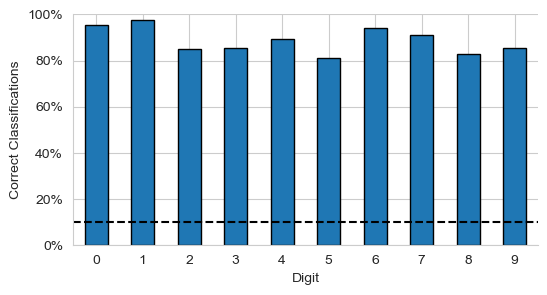

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

predictions_df.group_by(
    'actual'
).agg(
    pl.col('correct').mean()
).sort(
    'actual'
).to_pandas().plot(
    kind='bar',
    x='actual',
    y='correct',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.tick_params(
    axis='x',
    rotation=0,
)
ax.axhline(
    y=0.1, 
    color='k', 
    linestyle='--',
)
ax.set_xlabel('Digit')
ax.set_ylabel('Correct Classifications')
ax.set_ylim(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.show()

The following code block uses a heatmap to help understand the type of misclassifications that are being made.

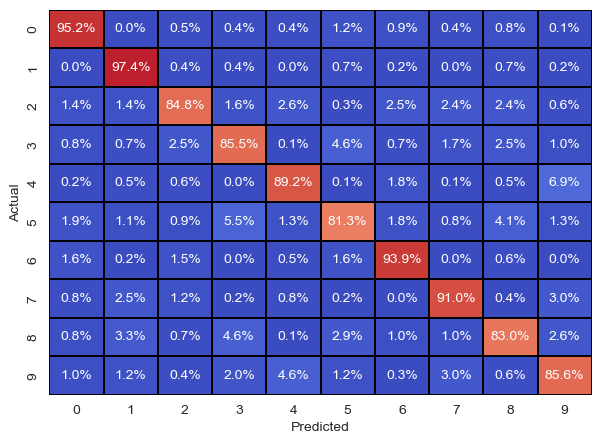

In [8]:
misclassifications_df = predictions_df.pivot(
    index='actual',
    on='predicted',
    values='correct',
    aggregate_function='len'
).fill_null(0).to_pandas().set_index(
    'actual'
).sort_index().sort_index(
    axis=1
)
misclassifications_df = misclassifications_df.divide(
    misclassifications_df.sum(axis=1),
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(
    misclassifications_df,
    cmap='coolwarm',
    vmax=1.0,
    vmin=0.0,
    linewidths=0.1,
    linecolor='k',
    cbar=False,
    annot=True,
    fmt='.1%'
)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()

## PyTorch Implementation

The following code block imports the libraries and modules we will need for the PyTorch implementation. We also set the seed for PyTorch's random number generator.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(42) 

The following code block defines hyperparameters for the PyTorch implementation.

In [10]:
input_size = 784  
hidden_size = 64  
output_size = 10
learning_rate = 0.01
epochs = 250
batch_size = 32


# 1. `batch_size = len(X_train)` and `learning_rate=0.3`
# 2. `batch_size = len(X_train)` and `learning_rate=0.001`
# 3. `batch_size = 64` and `learning_rate=0.3`
# 4. `batch_size = 64` and `learning_rate=0.001`

We will use a `DataLoader` to pass data to the PyTorch model in batches. To use a `DataLoader`, we need to first create a class for our dataset that we can pass to it. Our class will inherit from the `DataSet` object we imported from `torch.utils.data` and must define the `__len__` and `__getitem__` methods.

In [11]:
class MNISTDataset(Dataset):
    def __init__(self, data_array, label_array):
        self.data = data_array
        self.labels = label_array
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        data_row = self.data[idx].astype(np.float32) # Demonstrate problems if this is not done
        label_row = self.labels[idx].astype(np.float32) # Demonstrate problems if this is not done

        return data_row, label_row

The following code block uses our `MNISTDataset` class to create datasets for the training, validation, and test sets. We then use these to create `DataLoader` objects that batch the data.

In [12]:
train_dataset = MNISTDataset(
    data_array=X_train, 
    label_array=y_train,
)
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=batch_size,
    shuffle=True,
)

validation_dataset = MNISTDataset(
    data_array=X_validation, 
    label_array=y_validation,
)
validation_dataloader = DataLoader(
    dataset=validation_dataset, 
    batch_size=batch_size,
    shuffle=True,
)

test_dataset = MNISTDataset(
    data_array=X_test, 
    label_array=y_test,
)
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size,
    shuffle=True,
)

The following code block gets one batch of feature and label data from the training dataloader and prints the shape and dtypes of the returned objects.

In [13]:
for features, labels in train_dataloader:
    break

print(f' - {features.shape = }')
print(f' - {features.dtype = }')
print(f' - {labels.shape = }')
print(f' - {labels.dtype = }')

 - features.shape = torch.Size([32, 784])
 - features.dtype = torch.float32
 - labels.shape = torch.Size([32, 10])
 - labels.dtype = torch.float32


The following code block defines the PyTorch neural network model. Again, we use a class for this purpose. We define the layers and weight initialization in the classes `__init__` method. The steps of the forward pass are defined in the `__forward__` method. This implementation uses a Kaiming or He initialization that considers the non-linearity of activation functions, such as ReLU activations. 

In [14]:
class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.a1 = nn.Sigmoid()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

        # use kaiming
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.a1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

The following code block implements and runs the PyTorch neural network model. Because the training time can be long, model weights are saved whenever the model is trained so they can be loaded later without training.

In [15]:
train_pytorch_model = False

model = FFNN(
    input_size=input_size, 
    hidden_size=hidden_size, 
    output_size=output_size,
)
model_weights_path = pathlib.Path('mnist_model.pth')

if train_pytorch_model or (not model_weights_path.exists()):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(), 
        lr=learning_rate,
    )
    
    pytorch_training_history = []
    for epoch in tqdm(range(epochs)):
        model.train()
        training_running_loss = 0.0
        for batch_idx, (rows, labels) in enumerate(train_dataloader):
    
            # Foward pass
            outputs = model(rows)
            loss = criterion(outputs, labels)
    
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            training_running_loss += loss.item()
        
        training_loss = training_running_loss/len(train_dataloader)
        pytorch_training_history.append({
            'Epoch': epoch + 1,
            'Dataset': 'Training',
            'Loss': training_loss,
        })
    
        model.eval()
        validation_running_loss = 0.0
        with torch.no_grad():
            for batch_idx, (rows, labels) in enumerate(validation_dataloader):
    
                outputs = model(rows)
                loss = criterion(outputs, labels)
                validation_running_loss += loss.item()
        
        validation_loss = validation_running_loss/len(validation_dataloader)
        pytorch_training_history.append({
            'Epoch': epoch + 1,
            'Dataset': 'Validation',
            'Loss': validation_loss,
        })
    
    torch.save(
        obj=model.state_dict(), 
        f=str(model_weights_path),
    )
    
    pytorch_training_history = pl.DataFrame(pytorch_training_history)
        
    fig, ax = plt.subplots(1, 1, figsize=(5, 3))
        
    sns.lineplot(
        data=pytorch_training_history,
        x='Epoch',
        y='Loss',
        hue='Dataset',
    )
    ax.set_title('Training Progress')
    plt.savefig(
        'PyTorch_training_progress.png',
        bbox_inches='tight',
        dpi=600,
    )
    plt.show()
else:
    model.load_state_dict(
        torch.load(str(model_weights_path), weights_only=True)
    ) 

# Evaluate model on test data
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for rows, labels in test_dataloader:
        
        outputs = model(rows)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.argmax(axis=1)).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 93.58%


### Performance assessment: PyTorch Implementation

The following code block creates a `polars DataFrame` that includes the predictions and actual labels for instances in the test data.

In [16]:
feature_tensor = torch.tensor(X_test.astype(np.float32))
outputs = model(feature_tensor)
predictions = outputs.argmax(axis=1).numpy()

predictions_df = pl.DataFrame().with_columns(
    pl.Series(name='actual', values=np.argmax(y_test, axis=1)),
    pl.Series(name='predicted', values=predictions)
).with_columns(
    correct = pl.when(
        pl.col('actual') == pl.col('predicted')
    ).then(1).otherwise(0)
)

The following code block shows the correct classifications by digit.

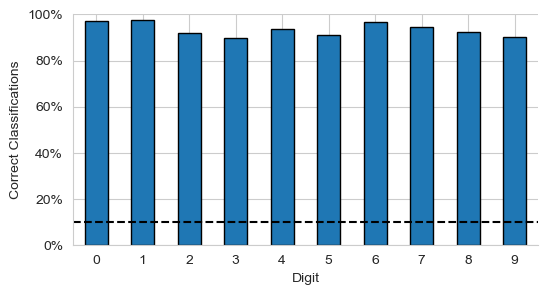

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))

predictions_df.group_by(
    'actual'
).agg(
    pl.col('correct').mean()
).sort(
    'actual'
).to_pandas().plot(
    kind='bar',
    x='actual',
    y='correct',
    ax=ax,
    edgecolor='k',
    legend=False,
)
ax.tick_params(
    axis='x',
    rotation=0,
)
ax.axhline(
    y=0.1, 
    color='k', 
    linestyle='--',
)
ax.set_xlabel('Digit')
ax.set_ylabel('Correct Classifications')
ax.set_ylim(0, 1)
ax.spines[['right', 'top']].set_visible(False)
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1))

plt.show()

The following code block uses a heatmap to help understand the type of misclassifications that are being made.

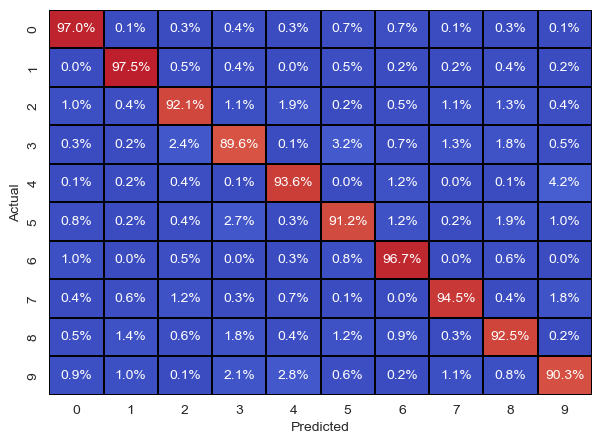

In [18]:
misclassifications_df = predictions_df.pivot(
    index='actual',
    on='predicted',
    values='correct',
    aggregate_function='len'
).fill_null(0).to_pandas().set_index(
    'actual'
).sort_index().sort_index(
    axis=1
)
misclassifications_df = misclassifications_df.divide(
    misclassifications_df.sum(axis=1),
    axis=0
)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

sns.heatmap(
    misclassifications_df,
    cmap='coolwarm',
    vmax=1.0,
    vmin=0.0,
    linewidths=0.1,
    linecolor='k',
    cbar=False,
    annot=True,
    fmt='.1%'
)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

plt.show()